# <p align="center">**Pré-Processamento e Vetorização** 🧬</p>
 
##### <p align="center">**Autores:**  Glauber Nascimento & Lorena Ribeiro</p>
##### <p align="center">**Orientador:**  James Moraes de Almeida  </p>
 

<div style="background-color: lightblue; font-size: 18px; padding: 10px;">
<div style="text-align: justify"><strong>Objetivo:</strong> Classificar imagens de folhas de plantas em saudáveis e doentes, e diferenciar suas patologias a partir de Processamento de Imagens utilizando CNN.</div>

## 📚Importando bibliotecas 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

plt.style.use('classic')

import optuna                  #bibliotecas para otimização
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.models import Sequential


from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, to_categorical
from keras.layers import Dropout
from keras.optimizers import SGD, RMSprop

2025-11-16 17:43:27.522394: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-16 17:43:27.576552: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 17:43:31.520782: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## ⚖️Verificando o balanceamento das imagens

In [2]:
base_dir = "plant-disease-recognition-dataset/Train/Train"

train_healthy = []
train_powd = []
train_rusty = []

for classe in os.listdir(base_dir):
    caminho = os.path.join(base_dir, classe)
    if os.path.isdir(caminho):
        n_imagens = len(os.listdir(caminho))

        if classe == 'Healthy':
            train_healthy.append(n_imagens)
        elif classe == 'Powdery':
            train_powd.append(n_imagens)
        else:
            train_rusty.append(n_imagens)
        
        print(f"{classe}: {n_imagens} imagens")


Healthy: 458 imagens
.ipynb_checkpoints: 0 imagens
Powdery: 430 imagens
Rust: 434 imagens


In [3]:
base_dir = "plant-disease-recognition-dataset/Validation/Validation"

val_healthy = []
val_powd = []
val_rusty = []

for classe in os.listdir(base_dir):
    caminho = os.path.join(base_dir, classe)
    if os.path.isdir(caminho):
        n_imagens = len(os.listdir(caminho))

        if classe == 'Healthy':
            val_healthy.append(n_imagens)
        elif classe == 'Powdery':
            val_powd.append(n_imagens)
        else:
            val_rusty.append(n_imagens)
        
        print(f"{classe}: {n_imagens} imagens")


Rust: 20 imagens
Healthy: 20 imagens
.ipynb_checkpoints: 0 imagens
Powdery: 20 imagens


In [4]:
base_dir = "plant-disease-recognition-dataset/Test/Test"

test_healthy = []
test_powd = []
test_rusty = []

for classe in os.listdir(base_dir):
    caminho = os.path.join(base_dir, classe)
    if os.path.isdir(caminho):
        n_imagens = len(os.listdir(caminho))

        if classe == 'Healthy':
        
            test_healthy.append(n_imagens)
        elif classe == 'Powdery':
        
            test_powd.append(n_imagens)
        else:
        
            test_rusty.append(n_imagens)
        
        print(f"{classe}: {n_imagens} imagens")

Healthy: 51 imagens
.ipynb_checkpoints: 0 imagens
Powdery: 50 imagens
Rust: 50 imagens


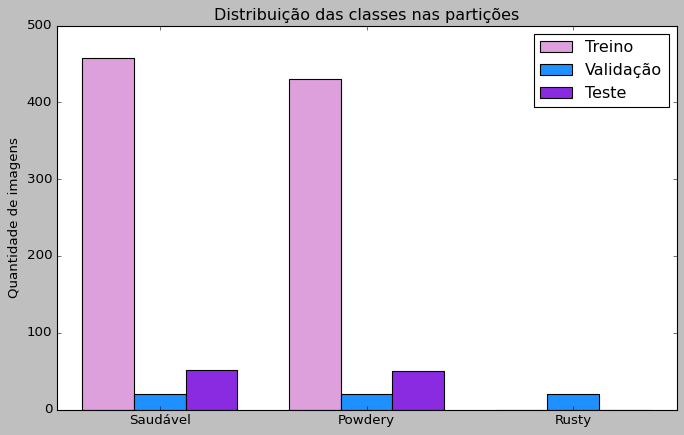

In [5]:
plt.figure(figsize=(10, 6))

labels = ['Saudável', 'Powdery', 'Rusty']

test  = [int(test_healthy[0]),  int(test_powd[0]),  int(test_rusty[0])]
val   = [int(val_healthy[0]),   int(val_powd[0]),   int(val_rusty[0])]
train = [int(train_healthy[0]), int(train_powd[0]), int(train_rusty[0])]

x = np.arange(len(labels))  # posições básicas: 0,1,2
width = 0.25                # largura de cada barra

plt.bar(x - width, train, width, label='Treino', color='plum')
plt.bar(x, val, width, label='Validação', color='dodgerblue')
plt.bar(x + width, test,  width, label='Teste', color='blueviolet')

plt.xticks(x, labels)
plt.title("Distribuição das classes nas partições")
plt.ylabel("Quantidade de imagens")
plt.legend()
plt.show()


## 🗂️Carregamento do dataset

In [6]:
'''Exemplo com Cifar10 para o carregamento'''

# (X_train, y_train), (X_test, y_test) = cifar10.load_data()
# print("The size of training dataset X is: ", X_train.shape)
# print("The size of testing dataset X is: ", X_test.shape)

# print("The size of training dataset y is: ", y_train.shape)
# print("The size of testing dataset y is: ", y_test.shape)

'Exemplo com Cifar10 para o carregamento'

In [7]:
"""Verificando o tamanho da imagem"""
from PIL import Image

base_dir = "plant-disease-recognition-dataset/Train/Train"
tamanhos = set()

for classe in os.listdir(base_dir):
    pasta_classe = os.path.join(base_dir, classe)
    if os.path.isdir(pasta_classe):
        for arquivo in os.listdir(pasta_classe):
            caminho = os.path.join(pasta_classe, arquivo)
            img = Image.open(caminho)
            tamanhos.add(img.size)

print("Tamanhos encontrados:", tamanhos)


Tamanhos encontrados: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (4608, 3456), (2421, 2279)}


Visto que nossas imagens tem alta resolução, conforme os tamanhos encontrados no dataset, poderiamos seguir por duas vertentes: 224x224 ou 128z128. A primeira preserva mais os detalhes, todavia é mais interessante para modelos com pesos pré-treinados, que não é o caso do nosso projeto. Sendo assim, será utilizado o tamanho 128x128, visto que tem menor custo computacional e não precisa de um pré-treinamento, tentando superar as barreriras devido a perda de detalhes finos 

In [8]:
import tensorflow as tf

# Caminhos das pastas do dataset
train_dir = "plant-disease-recognition-dataset/Train/Train"
val_dir   = "plant-disease-recognition-dataset/Validation/Validation"
test_dir  = "plant-disease-recognition-dataset/Test/Test"

# Parâmetros (ajuste do tamanho da imagem)
img_size = (128, 128)   
batch_size = 32

# Carregar os datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="int",        # igual ao CIFAR, produz y no formato inteiro
    seed=710,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="int",
    seed=7200,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="int",
    seed=710,
    image_size=img_size,
    batch_size=batch_size
)

# Mostrar classes detectadas
class_names = train_ds.class_names
print("Classes detectadas:", class_names)

# "X" e "y" equivalentes
X_train, y_train = [], []
for batch_x, batch_y in train_ds:
    X_train.append(batch_x)
    y_train.append(batch_y)

X_test, y_test = [], []
for batch_x, batch_y in test_ds:
    X_test.append(batch_x)
    y_test.append(batch_y)

# Converter listas para tensores grandes (opcional)
X_train = tf.concat(X_train, axis=0)
y_train = tf.concat(y_train, axis=0)
X_test  = tf.concat(X_test, axis=0)
y_test  = tf.concat(y_test, axis=0)

print("The size of training dataset X is:", X_train.shape)
print("The size of testing dataset X is:", X_test.shape)

print("The size of training dataset y is:", y_train.shape)
print("The size of testing dataset y is:", y_test.shape)


Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 151 files belonging to 3 classes.
Classes detectadas: ['Healthy', 'Powdery', 'Rust']


2025-11-16 17:43:41.619947: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-16 17:43:51.166214: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The size of training dataset X is: (1322, 128, 128, 3)
The size of testing dataset X is: (151, 128, 128, 3)
The size of training dataset y is: (1322,)
The size of testing dataset y is: (151,)


2025-11-16 17:43:52.501047: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
X_train = X_train.numpy()
X_test = X_test.numpy()


In [10]:
X_train = (X_train.astype('float32')) / 255.
X_test = (X_test.astype('float32')) / 255.


## 📈Otimizando hiperparâmetros

In [11]:

# def intancia_modelo(trial):

#     # Definindo os hiperparâmetros
#     parametros={trial.suggest_categorical(
#         "kernel_initializer", ["he_uniform", "random_uniform"]
#     ), "activation":trial.suggest_categorical(
#         "activation", ["relu", "tanh"]
#     ),   "dropout_rate": trial.suggest_float(
#         "dropout", 0.1, 0.5
#     ),"learning_rate": trial.suggest_float(
#         "lr", 1e-4, 1e-2, log=True
#     ),  "n_jobs": -1}

#     # Número de filtros
#     filters1 = trial.suggest_categorical("filters1", [16, 32, 64])    #1 convolução
#     filters2 = trial.suggest_categorical("filters2", [32, 64, 128])    #2 convolução

#    # Modelo  
#     model = Sequential([
#         tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)), 

#         Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
#         Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
#         MaxPooling2D((2,2)),
#         Dropout(dropout_rate),

#         Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
#         Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
#         MaxPooling2D((2,2)),
#         Dropout(dropout_rate),

#         Flatten(),
#         Dense(256, activation=activation, kernel_initializer=kernel_initializer),
#         Dropout(dropout_rate),

#         Dense(3, activation='softmax')
#     ])


    
    


In [12]:
# def funcao_objetivo(trial, X, y, num_folds):
#     """Função objetivo do Optuna para classificação (diagnóstico de doença)"""
#     modelo = instancia_modelo(trial)
#     optimizer = SGD(learning_rate=lr, momentum=0.9)

#     metricas = cross_val_score(
#         modelo,
#         X,
#         y,
#         optimizer=optimizer,
#         loss="sparse_categorical_crossentropy",
#         scoring="acuracy",  # prioriza sensibilidade
#         cv=num_folds,
#         n_jobs=-1
#     )
   

#     return -val_acc #sinal de menos pois o padrão do optuna é minimizar 

    

In [13]:
def instancia_modelo(trial):

    # Hiperparâmetros sugeridos pelo Optuna
    parametros = {
        "kernel_initializer": trial.suggest_categorical(
            "kernel_initializer", ["he_uniform", "random_uniform"]
        ),
        "activation": trial.suggest_categorical(
            "activation", ["relu", "tanh"]
        ),
        "dropout_rate": trial.suggest_float(
            "dropout", 0.1, 0.5
        ),
        "learning_rate": trial.suggest_float(
            "lr", 1e-4, 1e-2, log=True
        ),
        "n_jobs": -1
    }

    # Acessando os valores
    kernel_initializer = parametros["kernel_initializer"]
    activation = parametros["activation"]
    dropout_rate = parametros["dropout_rate"]
    lr = parametros["learning_rate"]

    # NÚMERO DE FILTROS
    filters1 = trial.suggest_categorical("filters1", [16, 32, 64])
    filters2 = trial.suggest_categorical("filters2", [32, 64, 128])

    # MODELO
    model = Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)),

        Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),

        Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(256, activation=activation, kernel_initializer=kernel_initializer),

        Dense(3, activation='softmax')
    ])

    # Otimizador (importante!)
    optimizer = SGD(learning_rate=lr, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [14]:
def funcao_objetivo(trial):

    model = instancia_modelo(trial)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=5,
        batch_size=32,
        verbose=0
    )

    val_acc = history.history["val_accuracy"][-1]

    return val_acc

In [15]:
study = optuna.create_study(
    direction="maximize",
    study_name="CNN_semproc__optuna_final",
    storage="sqlite:///cnn_optuna.db",
    load_if_exists=True
)

study.optimize(funcao_objetivo, n_trials=50)


[I 2025-11-16 17:43:53,588] A new study created in RDB with name: CNN_semproc__optuna_final
/home/lorena24014/anaconda3/envs/img_proc/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-11-16 17:44:54,865] Trial 0 finished with value: 0.324528306722641 and parameters: {'kernel_initializer': 'random_uniform', 'activation': 'tanh', 'dropout': 0.37156158997963795, 'lr': 0.0006753575321654448, 'filters1': 32, 'filters2': 64}. Best is trial 0 with value: 0.324528306722641.
[I 2025-11-16 17:47:07,198] Trial 1 finished with value: 0.3132075369358063 and parameters: {'kernel_initializer': 'he_uniform', 'activation': 'relu', 'dropout': 0.27357327492777417, 'lr': 0.0012472925302895743, 'filters1': 64, 'filters2': 128}. Best is trial 0 with value: 0.3245

In [16]:
print("Melhores parâmetros:")
for k, v in study.best_params.items():
    print(k, ":", v)

print("Melhor accuracy:", study.best_value)


Melhores parâmetros:
kernel_initializer : he_uniform
activation : tanh
dropout : 0.21344892949690397
lr : 0.006930285446163739
filters1 : 64
filters2 : 64
Melhor accuracy: 0.4226415157318115


## ⛏️Construindo a CNN

In [17]:
# Pega os melhores parâmetros do Optuna
best_params = study.best_params

kernel_initializer = best_params["kernel_initializer"]
activation = best_params["activation"]
drop = best_params["dropout"]
lr = best_params["lr"]
filters1 = best_params["filters1"]
filters2 = best_params["filters2"]

num_classes = 3

model1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)),

    # Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
    Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
    MaxPooling2D((2,2)),
    Dropout(drop),

    # Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
    Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
    MaxPooling2D((2,2)),
    Dropout(drop),

    Flatten(),
    Dense(512, activation=activation, kernel_initializer=kernel_initializer),
    # Dropout(drop),

    Dense(num_classes, activation='softmax')
])

# Otimizador com LR otimizado
opt = SGD(learning_rate=lr, momentum=0.9)

model1.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_50 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 64, 64, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,595,203 (128.16 MB)

 Trainable params: 33,595,203 (128.16 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 582ms/step - accuracy: 0.3389 - loss: 1.1022 - val_accuracy: 0.3377 - val_loss: 1.0978
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 590ms/step - accuracy: 0.3548 - loss: 1.1002 - val_accuracy: 0.3377 - val_loss: 1.0937
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 587ms/step - accuracy: 0.3873 - loss: 1.1003 - val_accuracy: 0.3377 - val_loss: 1.1063
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 572ms/step - accuracy: 0.3865 - loss: 1.0859 - val_accuracy: 0.3510 - val_loss: 1.0901
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 583ms/step - accuracy: 0.4266 - loss: 1.0677 - val_accuracy: 0.3377 - val_loss: 1.0859
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 574ms/step - accuracy: 0.4274 - loss: 1.0648 - val_accuracy: 0.3311 - val_loss: 1.2016
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 591ms/step - accuracy: 0.4395 - loss: 1.0421 - val_accuracy: 0.3576 - val_loss: 1.0759
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 559ms/step - accuracy: 0.5340 - loss: 0.9893 - val_accu

In [19]:
_, acc = model1.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.3245 - loss: 1.2999


In [20]:
print("Accuracy = ", (acc * 100.0), "%")

Accuracy =  32.45033025741577 %


In [21]:
#predições a partir do modelo de teste
y_pred_prob = model1.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matriz_confusao = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusao,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)

# 🔹 Aumentar fonte dos ticks (labels nos eixos)
ax.tick_params(axis='both', labelsize=14)

# 🔹 Rotacionar labels do eixo X
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# 🔹 Aumentar fonte dos labels dos eixos
ax.set_xlabel("Predito", fontsize=18)
ax.set_ylabel("Real", fontsize=18)

# 🔹 Aumentar fonte do título
plt.title("Matriz de Confusão - CNN sem Pré-processamento com Optuna", fontsize=22)

plt.show()


NameError: name 'confusion_matrix' is not defined